In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn joblib fastapi uvicorn scorecardpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
import scorecardpy as sc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('/content/data.csv')

In [3]:
# Data Overview
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

In [4]:
# Check for and handle missing values
df.fillna(0, inplace=True)  # or use more sophisticated imputation methods

In [5]:
# Remove outliers
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[feature] >= Q1 - 1.5 * IQR) & (df[feature] <= Q3 + 1.5 * IQR)]

df = remove_outliers(df, 'Amount')
df = remove_outliers(df, 'Value')

In [6]:
# Check class balance for the target variable
class_balance = df['FraudResult'].value_counts(normalize=True)
print("Class Balance of FraudResult:")
print(class_balance)

Class Balance of FraudResult:
FraudResult
0    0.999969
1    0.000031
Name: proportion, dtype: float64


<ipython-input-7-8c6ee647a94e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FraudResult', data=df, palette='viridis')


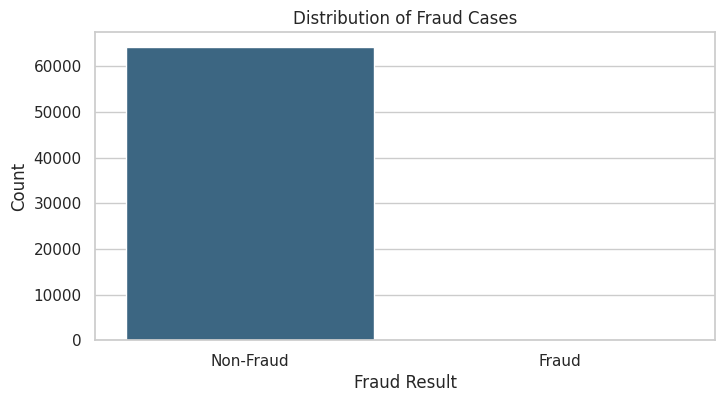

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Plot the distribution of FraudResult
plt.figure(figsize=(8, 4))
sns.countplot(x='FraudResult', data=df, palette='viridis')
plt.title('Distribution of Fraud Cases')
plt.xlabel('Fraud Result')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

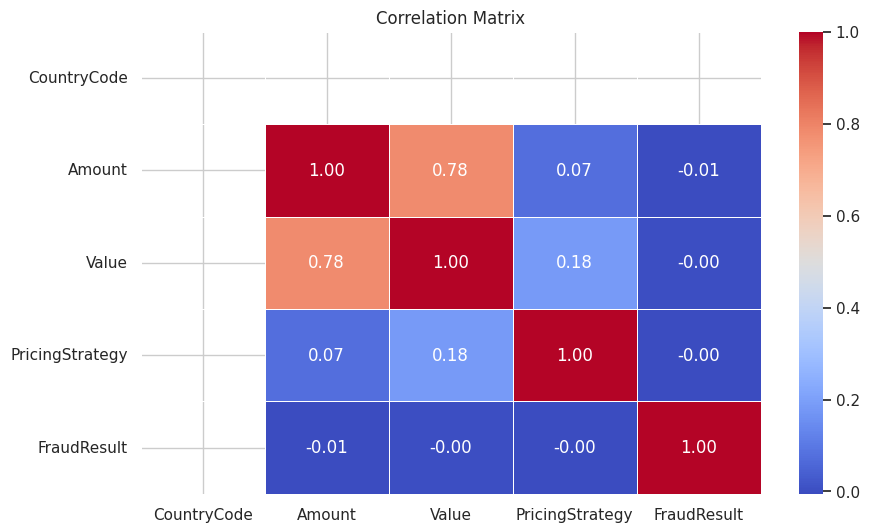

In [8]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [9]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
missing_values[missing_values > 0]  # Display only columns with missing values

,0


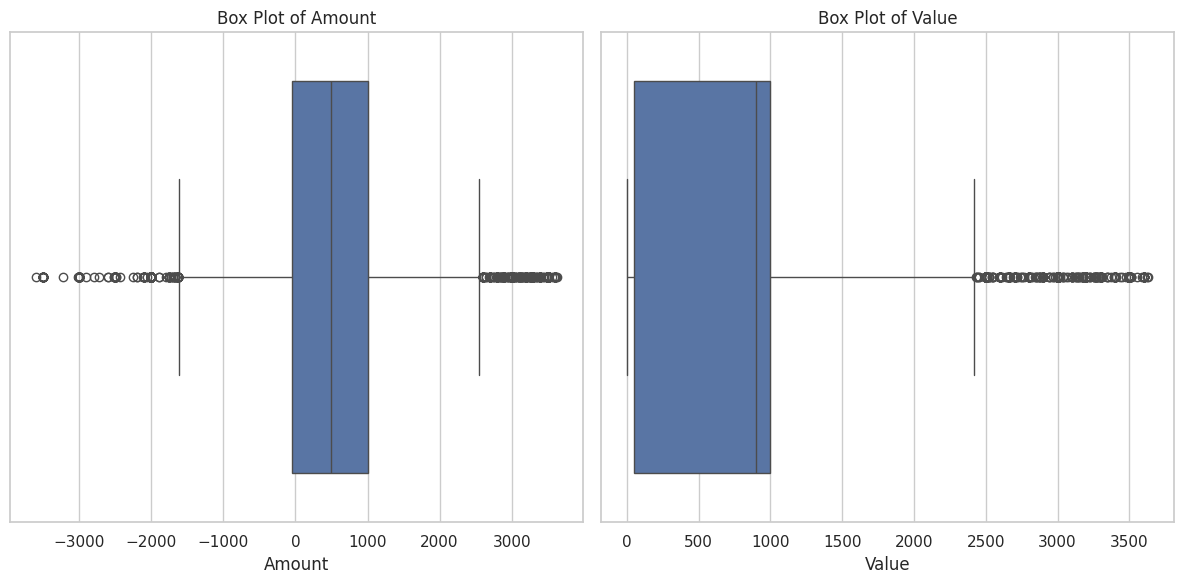

In [10]:
# Create box plots for numerical features to detect outliers
numerical_features = ['Amount', 'Value']  # Add any other numerical features as needed

plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

In [11]:
# Function to remove outliers based on IQR
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers for 'Amount' and 'Value'
df_no_outliers = remove_outliers(df, 'Amount')
df_no_outliers = remove_outliers(df_no_outliers, 'Value')

# Check the shape of the new DataFrame
df_no_outliers.shape

(61242, 16)

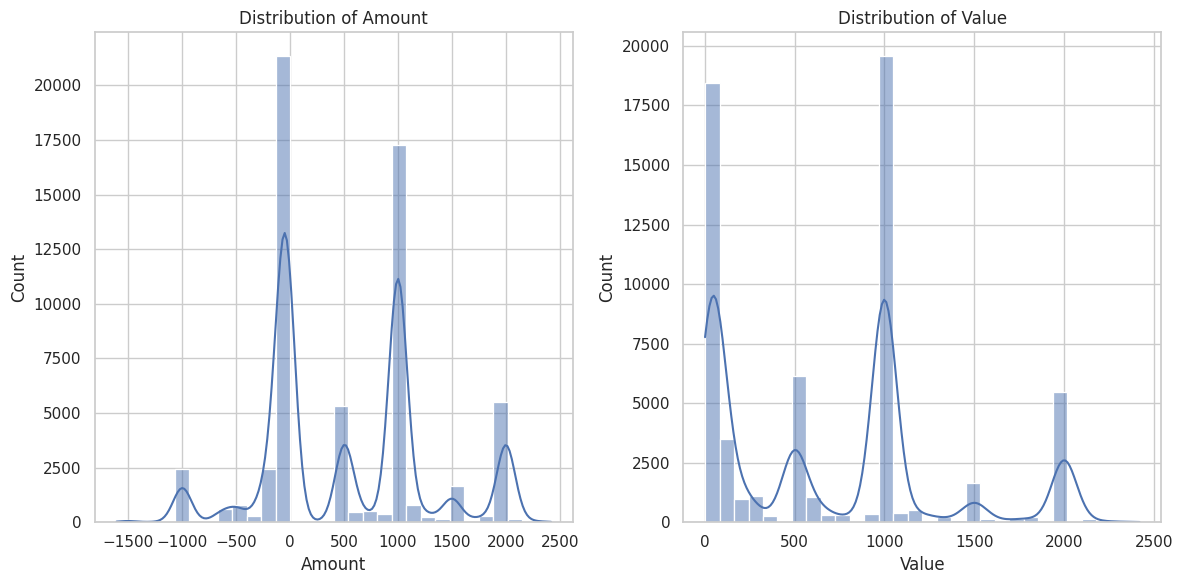

In [12]:
# Visualize the distribution of numerical features
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)
    sns.histplot(df_no_outliers[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

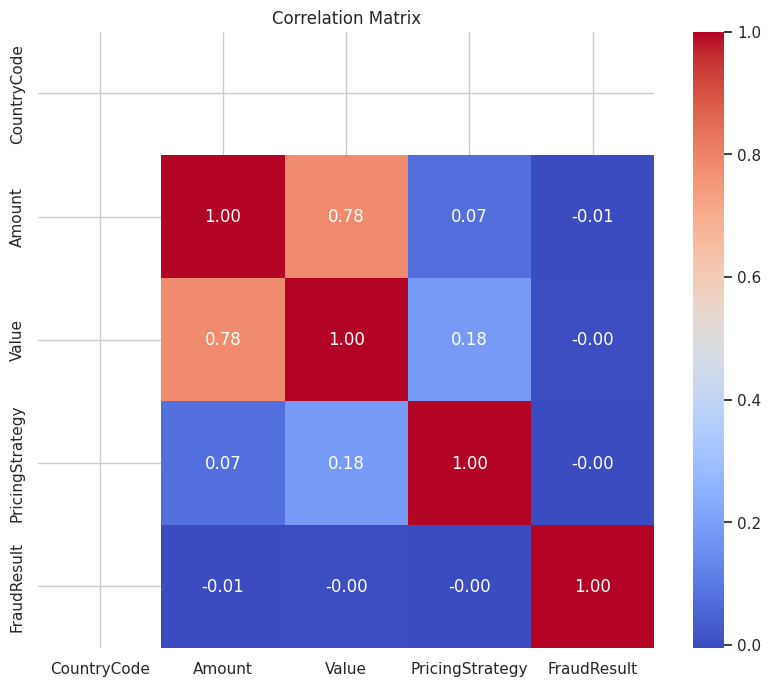

In [13]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix')
plt.show()

Feature Engineering

In [14]:
# Check the columns of the DataFrame
df_no_outliers.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [15]:
# Create aggregate features
aggregate_features = df_no_outliers.groupby('CustomerId').agg({
    'Amount': ['sum', 'mean', 'count', 'std'],
    'Value': ['sum', 'mean', 'count', 'std']
}).reset_index()

# Rename the columns for clarity
aggregate_features.columns = ['CustomerId',
                              'Total_Transaction_Amount', 'Average_Transaction_Amount', 'Transaction_Count', 'Std_Dev_Transaction_Amount',
                              'Total_Value', 'Average_Value', 'Value_Count', 'Std_Dev_Value']

# Merge back to the original DataFrame
df_no_outliers = df_no_outliers.merge(aggregate_features, on='CustomerId', how='left')

In [16]:
# Ensure 'TransactionStartTime' is in datetime format
df_no_outliers['TransactionStartTime'] = pd.to_datetime(df_no_outliers['TransactionStartTime'])

# Extract time-related features
df_no_outliers['Transaction_Hour'] = df_no_outliers['TransactionStartTime'].dt.hour
df_no_outliers['Transaction_Day'] = df_no_outliers['TransactionStartTime'].dt.day
df_no_outliers['Transaction_Month'] = df_no_outliers['TransactionStartTime'].dt.month
df_no_outliers['Transaction_Year'] = df_no_outliers['TransactionStartTime'].dt.year

In [17]:
# One-Hot Encoding for categorical variables
df_no_outliers = pd.get_dummies(df_no_outliers, columns=['CountryCode', 'PricingStrategy'], drop_first=True)

# Label Encoding for binary categorical variables
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_no_outliers['FraudResult'] = label_encoder.fit_transform(df_no_outliers['FraudResult'])

In [18]:
# Impute missing values for specific columns
df_no_outliers['Std_Dev_Transaction_Amount'] = df_no_outliers['Std_Dev_Transaction_Amount'].fillna(0)
df_no_outliers['Std_Dev_Value'] = df_no_outliers['Std_Dev_Value'].fillna(0)

In [19]:
# Check for missing values again
missing_values_after = df_no_outliers.isnull().sum()
print(missing_values_after)

TransactionId                 0
BatchId                       0
AccountId                     0
SubscriptionId                0
CustomerId                    0
CurrencyCode                  0
ProviderId                    0
ProductId                     0
ProductCategory               0
ChannelId                     0
Amount                        0
Value                         0
TransactionStartTime          0
FraudResult                   0
Total_Transaction_Amount      0
Average_Transaction_Amount    0
Transaction_Count             0
Std_Dev_Transaction_Amount    0
Total_Value                   0
Average_Value                 0
Value_Count                   0
Std_Dev_Value                 0
Transaction_Hour              0
Transaction_Day               0
Transaction_Month             0
Transaction_Year              0
PricingStrategy_1             0
PricingStrategy_2             0
PricingStrategy_4             0
dtype: int64


Default Estimator

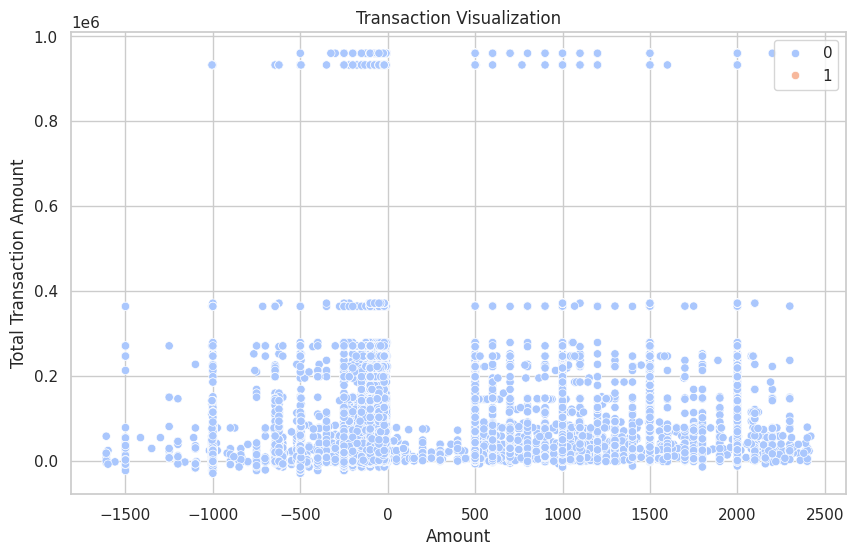

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Amount vs Total_Transaction_Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_no_outliers, x='Amount', y='Total_Transaction_Amount', hue='FraudResult', palette='coolwarm')
plt.title('Transaction Visualization')
plt.xlabel('Amount')
plt.ylabel('Total Transaction Amount')
plt.legend()
plt.show()

In [21]:
# Assuming df_no_outliers is your DataFrame with transaction data
df_no_outliers['TransactionStartTime'] = pd.to_datetime(df_no_outliers['TransactionStartTime'])

# Calculate Recency
current_date = df_no_outliers['TransactionStartTime'].max()  # Most recent transaction date
df_no_outliers['Recency'] = (current_date - df_no_outliers['TransactionStartTime']).dt.days

# Calculate Frequency
frequency = df_no_outliers.groupby('CustomerId').size().reset_index(name='Frequency')

# Calculate Monetary
monetary = df_no_outliers.groupby('CustomerId')['Total_Value'].sum().reset_index(name='Monetary')

# Calculate Recency for each customer
recency = df_no_outliers.groupby('CustomerId')['Recency'].min().reset_index()

# Merge RFMS metrics back into a single DataFrame
rfms = pd.merge(frequency, monetary, on='CustomerId')
rfms = pd.merge(rfms, recency, on='CustomerId', how='left')

# Display the RFMS DataFrame without duplicates
print(rfms)

           CustomerId  Frequency  Monetary  Recency
0     CustomerId_1001          1       200       89
1     CustomerId_1002         11     52525       25
2     CustomerId_1003          2      5000       11
3     CustomerId_1004          1      2000       52
4     CustomerId_1005          2      2400       46
...               ...        ...       ...      ...
3225   CustomerId_992          2      4000        4
3226   CustomerId_993          1      1000       25
3227   CustomerId_994         66   2120382        0
3228   CustomerId_996          1      1000       67
3229   CustomerId_998          2      3000       25

[3230 rows x 4 columns]


In [22]:
# Define scoring functions
def score_recency(recency):
    if recency <= 30:
        return 5
    elif recency <= 60:
        return 4
    elif recency <= 90:
        return 3
    elif recency <= 180:
        return 2
    else:
        return 1

def score_frequency(frequency):
    if frequency >= 10:
        return 5
    elif frequency >= 5:
        return 4
    elif frequency >= 3:
        return 3
    elif frequency >= 1:
        return 2
    else:
        return 1

def score_monetary(monetary):
    if monetary >= 100000:
        return 5
    elif monetary >= 50000:
        return 4
    elif monetary >= 10000:
        return 3
    elif monetary >= 1000:
        return 2
    else:
        return 1

# Apply scoring functions
rfms['Recency_Score'] = rfms['Recency'].apply(score_recency)
rfms['Frequency_Score'] = rfms['Frequency'].apply(score_frequency)
rfms['Monetary_Score'] = rfms['Monetary'].apply(score_monetary)

# Calculate Composite Score
rfms['Composite_Score'] = rfms['Recency_Score'] + rfms['Frequency_Score'] + rfms['Monetary_Score']

# Display the updated RFMS DataFrame
print(rfms)

           CustomerId  Frequency  Monetary  Recency  Recency_Score  \
0     CustomerId_1001          1       200       89              3   
1     CustomerId_1002         11     52525       25              5   
2     CustomerId_1003          2      5000       11              5   
3     CustomerId_1004          1      2000       52              4   
4     CustomerId_1005          2      2400       46              4   
...               ...        ...       ...      ...            ...   
3225   CustomerId_992          2      4000        4              5   
3226   CustomerId_993          1      1000       25              5   
3227   CustomerId_994         66   2120382        0              5   
3228   CustomerId_996          1      1000       67              3   
3229   CustomerId_998          2      3000       25              5   

      Frequency_Score  Monetary_Score  Composite_Score  
0                   2               1                6  
1                   5               4        

In [23]:
# Define a function to categorize customers
def categorize_customer(score):
    if score >= 12:
        return 'High Value'
    elif score >= 8:
        return 'Medium Value'
    else:
        return 'Low Value'

# Apply the categorization function
rfms['Customer_Segment'] = rfms['Composite_Score'].apply(categorize_customer)

# Display the updated RFMS DataFrame with segments
print(rfms[['CustomerId', 'Composite_Score', 'Customer_Segment']])

           CustomerId  Composite_Score Customer_Segment
0     CustomerId_1001                6        Low Value
1     CustomerId_1002               14       High Value
2     CustomerId_1003                9     Medium Value
3     CustomerId_1004                8     Medium Value
4     CustomerId_1005                8     Medium Value
...               ...              ...              ...
3225   CustomerId_992                9     Medium Value
3226   CustomerId_993                9     Medium Value
3227   CustomerId_994               15       High Value
3228   CustomerId_996                7        Low Value
3229   CustomerId_998                9     Medium Value

[3230 rows x 3 columns]


In [24]:
segment_counts = rfms['Customer_Segment'].value_counts()
print(segment_counts)

Customer_Segment
Medium Value    1603
High Value      1266
Low Value        361
Name: count, dtype: int64


In [25]:
# Adjust thresholds based on your analysis
threshold_amount = 0  # Adjust as necessary
threshold_total_amount = 20000  # Adjust as necessary

# Ensure df_no_outliers has the necessary columns
if 'Amount' in df_no_outliers.columns and 'Total_Transaction_Amount' in df_no_outliers.columns:
    # Reassign labels based on new thresholds
    df_no_outliers['Label'] = np.where(
        (df_no_outliers['Amount'] > threshold_amount) &
        (df_no_outliers['Total_Transaction_Amount'] > threshold_total_amount),
        'Bad', 'Good'
    )

    # Display the updated DataFrame with labels
    print(df_no_outliers[['Amount', 'Total_Transaction_Amount', 'Label']].head(10))
else:
    print("Columns 'Amount' and 'Total_Transaction_Amount' must be present in df_no_outliers.")

   Amount  Total_Transaction_Amount Label
0  1000.0                  48016.75   Bad
1   -20.0                  48016.75  Good
2   500.0                   1000.00  Good
3  -644.0                  12727.20  Good
4  2000.0                   2000.00  Good
5  -500.0                   6300.00  Good
6   500.0                   1060.00  Good
7   600.0                   1788.00  Good
8   890.0                  10700.00  Good
9   -40.0                  10700.00  Good


In [26]:
df_no_outliers['Label'].value_counts()

,count
Label,
Good,37001
Bad,24241


In [28]:
# Perform WoE binning for the relevant features, specifying the positive label
bins = sc.woebin(df_no_outliers, y='Label', x=['Amount', 'Total_Transaction_Amount'],
                 positive='Bad', save_breaks_list='breaks_list')

# Apply WoE transformation
df_woe = sc.woebin_ply(df_no_outliers, bins)

# Display the transformed DataFrame with WoE values
print(df_woe[['Amount_woe', 'Total_Transaction_Amount_woe', 'Label']].head(10))

[INFO] creating woe binning ...


/usr/local/lib/python3.11/dist-packages/scorecardpy/condition_fun.py:141: UserWarning: The positive value in "Label" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))
/usr/local/lib/python3.11/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.11/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,erro

[INFO] The breaks_list is saved as breaks_list_20250311_133709.py
[INFO] converting into woe values ...
   Amount_woe  Total_Transaction_Amount_woe Label
0    1.530491                      0.679685   Bad
1   -6.689286                      0.679685  Good
2    1.109446                     -1.349054  Good
3   -6.689286                     -1.349054  Good
4    1.530491                     -1.349054  Good
5   -6.689286                     -1.349054  Good
6    1.109446                     -1.349054  Good
7    1.109446                     -1.349054  Good
8    1.109446                     -1.349054  Good
9   -6.689286                     -1.349054  Good


Modeling

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7347
           1       1.00      0.85      0.92      4902

    accuracy                           0.94     12249
   macro avg       0.96      0.93      0.94     12249
weighted avg       0.95      0.94      0.94     12249



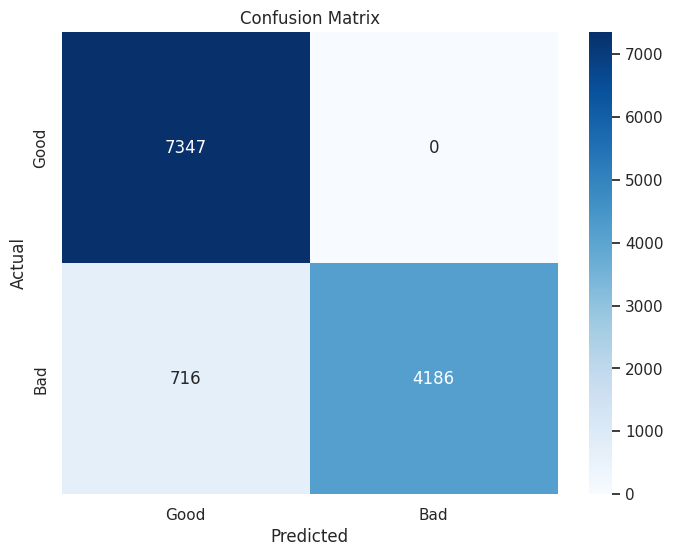

In [29]:
# Prepare features and target variable
X = df_woe[['Amount_woe', 'Total_Transaction_Amount_woe']]
y = df_woe['Label'].map({'Good': 0, 'Bad': 1})  # Convert labels to binary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Optional: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Save the trained model
joblib.dump(model, '/content/logistic_model.pkl')

['/content/logistic_model.pkl']